# Deep multimodal Two Stream Action Recognition

Import Deep Learning streams (Video and Pulse)

In [1]:
import numpy as np
from streams.rgbi3d import rgbi3d
from streams.cnn_lstm import cnn_lstm
from streams.two_stream import two_stream

Firstly, we obtain the action list with the name and identifier that this solution is able to identify

In [2]:
import json
with open("actions_list.json", "r") as file:
    actions_list = json.loads(file.read())

### Video Action Recognition Model
Create the video model instance with a reduced spatial resolution (112x112) to analyze 64 frames videos
recorded at 25 FPS (which represents 2.56 seconds clips). We also load the model trained
weights to perform action recognition.

In [3]:
video_model = rgbi3d(input_shape=(64, 112, 112, 3),
                     classes=10, endpoint_logit=False,
                     weights="weights/rgbi3d_model.hdf5")

#### 1. Load and preprocess an input video to perform action recognition
Firstly, import the *load_video* function from the preprocessing module. Then provide a path to a video you want to
analyze. We obtain a list of clips of 64 frames each that represent the video and a list with information of the timestamp
of the end of each clip. This information will be used below to retrieve pulse data.

In [4]:
from preprocessing.preprocessing import load_video
video_file_name = "20210114_152557-153300[152742.822000,152753.322000] (Subject 1).mp4"

video_clips, video_end_timestamp = load_video("data/{}".format(video_file_name),
                                              height=112, width=112,
                                              frames_wanted=64, step=64)

#### 2. Show the loaded video
Show the first clip of the video of a person walking. Note that **matplotlib** is required to plot the images

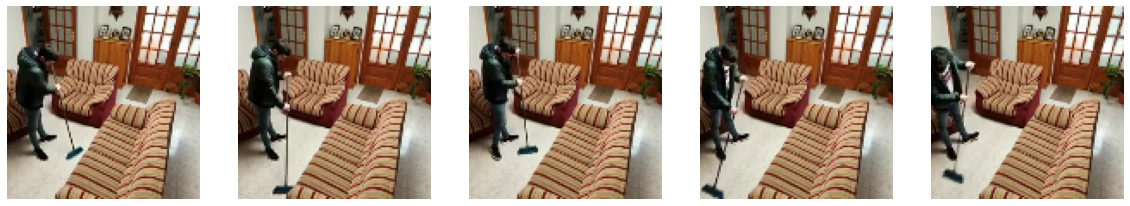

In [5]:
from utils.utils import show_video
show_video(video_clips[0], frames=5)

#### 3. Infer the activity using the optimized RGBI3D network
Firstly, we create a function to infer the data with the DL model easily

In [6]:
def predict_data(model, data, actions_list):
    prediction = model.predict(data, batch_size=8)
    prediction = prediction.mean(axis=0)
    detected_action = np.argmax(prediction, axis=-1)

    print("Action recognizer detected: {} - with a confidence of: {:0.2f}%".format(actions_list[str(detected_action)],
                                                                        prediction[detected_action]*100))

We analyze the video with the Video network. Note how the Video network identifies with a 98% confidence that someone is **cleaning**

In [7]:
predict_data(model=video_model, data=video_clips, actions_list=actions_list)

Action recognizer detected: cleaning - with a confidence of: 98.12%


### Pulses (PPG) Action Recognition Model
Create the pulses model instance with variable timesteps to provide more flexibility. Note that it was
originally trained using around 55 timesteps and with features of size 8 (55x8 = 440 data points). Every pulse signal was recorded
with a 66.67Hz sampling frequency (every 15ms). Therefore, around 440 data points represent 6.6 seconds
of the signal. We also load the model trained weights to perform action recognition.


For the pulses model, we only considered 9 actions, excluding the *no_action* class, because it makes no sense with this
kind of data

In [8]:
pulses_model = cnn_lstm(num_classes=9,
                        timesteps=None, # Variable timesteps size
                        features=8,
                        endpoint_logit=False,
                        weights="weights/cnn-lstm_pulse.hdf5")

#### 1. Load and preprocess pulse data to perform action recognition
Firstly, we retrieve the pulse signal depending on the retrieved video to get a synchronized signal.
For this, the video file name provides information about the date and initial and end hour of the clip. With this
information, we can retrieve the corresponding PPG signal of that period.


We import with pandas the pulse signal located in the data folder. Then, we normalize the signal
between negative 1 and 1.

In [9]:
import pandas as pd
pulse_data = "data/labeled_pulses.csv"
pulses = pd.read_csv(pulse_data)
numerator = pulses["blood_pressure"] - min(pulses["blood_pressure"])
denominator = max(pulses["blood_pressure"]) - min(pulses["blood_pressure"])
pulses["blood_pressure"] = 2  * (numerator / denominator) - 1

Concretely, the video name is formatted as follows:
```
date_videostarttime-videoendtime[clipstarttime,clipendtime] (Subject ID)
eg. 20210114_152557-153300[152854.072000,152858.822000] (Subject 1)
```
**Important**, timestamp values on the retrieved pandas dataframe with the following time zone: GMT +1. If you are in
a different time zone, *Review this*.

We retrieve a 6.6 seconds long signal ending at the same time each video clip finishes.

In [10]:
from preprocessing.preprocessing import load_pulses
n_timesteps = 55
n_features = 8

pulses_clips = np.empty((video_clips.shape[0], n_timesteps, n_features))
for i in range(len(video_end_timestamp)):
    pulses_clips[i] = load_pulses(video_end_timestamp[i],
                                  pulses,
                                  n_timesteps=n_timesteps,
                                  n_features=n_features)

#### 2. Show the loaded pulse signal
We show the pulses signal of the person from the previous video walking.

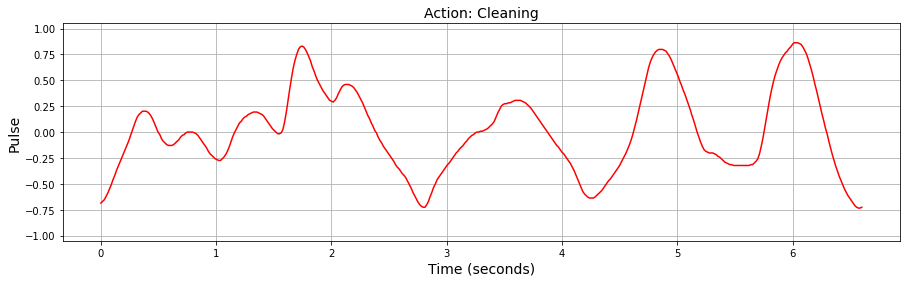

In [11]:
from utils.utils import plot_signal
plot_signal(pulses_clips[0], "Cleaning")


We analyze the PPG signal with the Pulses network. Note how the Pulse network identifies **cleaning** as the top action with a
confidence of 28%.

In [12]:
predict_data(model=pulses_model, data=pulses_clips, actions_list=actions_list)

Action recognizer detected: cleaning - with a confidence of: 28.55%


### Two Stream multimodal solution
Finally, we create the Multimodal Two Stream architecture from the RGBI3D and 1DCNN+LSTM networks. We also load the weights
of the WeighPerClass layer to weigh the contribution of every stream with respect to each action.

In [13]:
multimodal_ts = two_stream(rgb_model=video_model,
                           pulses_model=pulses_model,
                           weights="weights/ts_weights_per_class.npy")

After using the multimodal architecture, we obtained that someone is cleaning with a confidence higher than 96%.

In [14]:
predict_data(model=multimodal_ts, data=[video_clips, pulses_clips],
             actions_list=actions_list)


Action recognizer detected: cleaning - with a confidence of: 96.39%


#### 1. Critical action recognition
The development of this multimodal architecture enabled the enhancement of the recognition of critical actions.
Identify with high confidence when the patients suffer a potentially risky situation is crucial to
notify caregivers, reducing false alarms.

Below, we analyze two examples of critical actions (*Falling down* and *Lying on the floor*).

In [15]:
video_file_name_fall = "20210114_152557-153300[153142.821000,153146.572000] (Subject 1).mp4"
video_file_name_floor = "20210114_152557-153300[153037.572000,153042.500000] (Subject 1).mp4"


video_clips_fall, video_end_timestamp_fall = load_video("data/{}".format(video_file_name_fall),
                                                        height=112, width=112,
                                                        frames_wanted=64, step=64)

video_clips_floor, video_end_timestamp_floor = load_video("data/{}".format(video_file_name_floor),
                                                          height=112, width=112,
                                                          frames_wanted=64, step=64)

In [16]:
pulses_clips_fall = np.empty((video_clips_fall.shape[0], n_timesteps, n_features))
for i in range(len(video_end_timestamp_fall)):
    pulses_clips_fall[i] = load_pulses(video_end_timestamp_fall[i],
                                       pulses,
                                       n_timesteps=n_timesteps,
                                       n_features=n_features)

pulses_clips_floor = np.empty((video_clips_floor.shape[0], n_timesteps, n_features))
for i in range(len(video_end_timestamp_floor)):
    pulses_clips_floor[i] = load_pulses(video_end_timestamp_floor[i],
                                        pulses,
                                        n_timesteps=n_timesteps,
                                        n_features=n_features)

Once the input data is loaded (video and pulses), we evaluate the retrieved information using the
Two Stream multimodal architecture. Both activities are identified with high confidence.

Action recognizer detected: falling down - with a confidence of: 99.97%


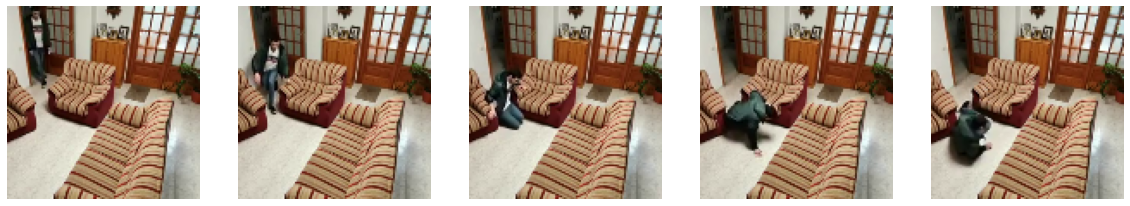

In [17]:
show_video(video_clips_fall[0], frames=5)
predict_data(model=multimodal_ts, data=[video_clips_fall, pulses_clips_fall],
             actions_list=actions_list)

Action recognizer detected: lying on the floor - with a confidence of: 94.27%


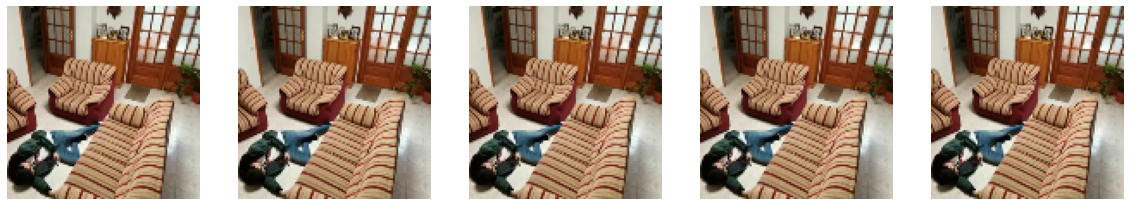

In [18]:
show_video(video_clips_floor[0], frames=5)
predict_data(model=multimodal_ts, data=[video_clips_floor, pulses_clips_floor],
             actions_list=actions_list)


Finally, note how the Pulses stream is able to recognize with relatively high confidence critical activities such as
**lying on the floor**. Taking into account the limitations about the information that this data can
provide when identifying actions. But also, considering the high efficiency of the stream that
analyzes the PPG (pulses signal) data.

In [19]:
predict_data(model=pulses_model, data=pulses_clips_floor, actions_list=actions_list)

Action recognizer detected: lying on the floor - with a confidence of: 57.42%
